##### Preamble/Imports

In [1]:
import matplotlib
matplotlib.use( "agg" )
%pylab inline

import plt_fmt

from numba import jit

from fig_annotate import *


from diffusion_integrator_funcs import *
from frac_brown import *

from brownian_integrator import *

Populating the interactive namespace from numpy and matplotlib


/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Three-dimensional radial equation

### Use LSODA integrator with variable step

In [35]:
# settings['SPACE_PTS'] = 100
# settings['ACTUAL_LENGTH'] = 10*params['POT_DIAM']

# settings['TIME_PTS'] = 1e6
# settings['START_TIME'] = 0.0
# settings['STOP_TIME'] = 17.0

# def packup_params(settings, params):
#     '''
#     Add some derived quantities to the parameters dictionary
    
    
#     '''
#     dt = (stop_time-start_time)/time_pts
#     times = linspace(start_time, stop_time, time_pts)
#     times = times + dt
#     settings['times'] = times
#     settings['dt'] = dt
    
#     dx = settings['ACTUAL_LENGTH']/settings['SPACE_PTS']
#     space = linspace(0.0, settings['ACTUAL_LENGTH'], settings['SPACE_PTS'])
#     space = space+dx
#     settings['space'] = space
#     settings['dx'] = dx
    
#     return [settings, params]
    

In [2]:
from scipy.integrate import ode

# def nxt_step(timepoint, yvals, settings_and_params):
#     settings, params = settings_and_params
# #     jac = jacob(timepoint, yvals, [settings, params])
#     jac = radiff_timeop(timepoint, yvals, [settings, params])
#     nxt_vals = jac.dot(yvals)
#     return nxt_vals

## pick parameter values
params = dict()

# width of overall potential well. smaller this is, the stronger the forcing
params['POT_DIAM'] = .05
params['KAPPA'] = 4e-1
params['DCOEFF'] = 1e-6
# alpha less than one
params['ALPHA']= .5


## set integrator settings
settings = dict()

# settings['SPACE_PTS'] = 100
# settings['ACTUAL_LENGTH'] = 10*params['POT_DIAM']

# settings['TIME_PTS'] = 1e6
# settings['START_TIME'] = 0.0
# settings['STOP_TIME'] = 17.0



space_pts = 100
ACTUAL_LENGTH = 10*params['POT_DIAM']


# width of reactive well
params['WELL_DIAM'] = .01


time_pts = 1e6
start_time = 0.0
stop_time = 1e3



# set integrator settings
settings = dict()

dt = (stop_time-start_time)/time_pts
times = linspace(start_time, stop_time, time_pts)
times = times + dt

dx = ACTUAL_LENGTH/space_pts
space = linspace(0.0, ACTUAL_LENGTH, space_pts)
space = space+dx

# initial conditions
y0 = ones(space_pts)

# settings['dx'] = dx
settings['space'] = space
settings['times'] = times

# settings['times'] = time_nondim(times, params)


# r = ode(nxt_step, jacob).set_integrator('vode', method='bdf', with_jacobian=True)
r = ode(nxt_step, radiff_timeop).set_integrator('lsoda', with_jacobian=True)
r.set_initial_value(y0, times[0])

r.set_f_params([settings, params])
r.set_jac_params([settings, params])

t1 = stop_time
sol = list()
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    sol.append(r.y)

sol = array(real(sol)).T


# now multiply through by the equilibrium distribution
gauss = eq_dist(space, params['POT_DIAM'])
# gauss = (1/sqrt(2*pi*params['POT_DIAM']**2))*exp(-space**2/(4*params['POT_DIAM']**2))
gauss = gauss[:, None]
sol = sol*gauss


# radpart = 4*pi*(space**2)
# radpart = radpart[:, None]
# sol = sol*radpart

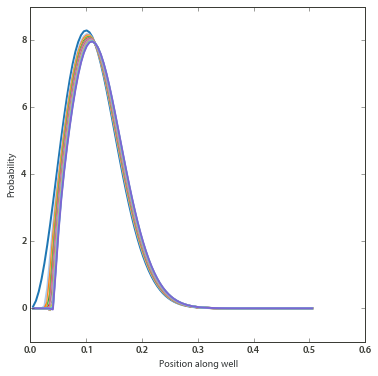

In [3]:
# plot time slices
figure()
solrange = len(sol[0,:])
num_slices = 20
hold(True)
slice_range = floor(solrange/num_slices)
for ii in range(num_slices):
    plot(space, sol[:,ii*slice_range])
plot(space, sol[:,-1])
# ylim([0,.05])
rcParams['font.family']='Open Sans'
xlabel("Position along well")
ylabel("Probability")
namestr = 'alpha_' + str(params['ALPHA']) + '__diffu_' + str(params['DCOEFF'])+'__kappa_' +\
str(params['KAPPA'])+'__reacdiam_' +str(params['WELL_DIAM'])+'__potdiam_' + str(params['POT_DIAM'])
# savefig(namestr+'.pdf')


# figure()
# figure() 
# total_conc = sum(sol, axis = 0)
# plot(times,total_conc[:-1])
# ylabel("Total count")
# xlabel("time")

In [90]:
# what happened to my k*T Boltzmann factor? has it been absorbed into pot_diam?
# I think that this constrains the relationship between k_{spring} and a^2

In [58]:
## pick parameter values

save_full_sol = False
save_fht = False

well_diams = linspace(.001,.1,40)
well_diams = expspace(.001,.1,40)

allsol = list() # not recommended for more than 10 points

all_fht = list()

all_timesums = list()


for diam in well_diams:
    
    params['POT_DIAM'] = diam
    
    # have to re-intialize because r is a generator
    r = ode(nxt_step, radiff_timeop).set_integrator('lsoda', with_jacobian=True)
    r.set_initial_value(y0, times[0])
    r.set_f_params([settings, params])
    r.set_jac_params([settings, params])
    t1 = stop_time
    
    sol = list()
    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        sol.append(r.y)
    sol = array(real(sol)).T
    
    gauss = exp(-space**2/(4*params['POT_DIAM']**2))
    gauss = gauss[:, None]
    sol = sol*gauss

    radpart = 4*pi*(space**2)
    radpart = radpart[:, None]
    sol = sol*radpart
    
    # integrate out space
    timesum = sum(sol, axis = 0)
    all_timesums.append( timesum )
    
    
    
    if save_full_sol:
        allsol.append( sol )
    
    if save_fht:
        all_fht.append( -diff(timesum) )
    
    
    print (diam)

0.001
0.0011253355826
0.00126638017347
0.0014251026703
0.00160371874375
0.00180472176683
0.0020309176209
0.00228546386413
0.00257191380906
0.00289426612472
0.00325702065566
0.00366524123708
0.0041246263829
0.00464158883361
0.00522334507427
0.00587801607227
0.00661474064123
0.00744380301325
0.00837677640068
0.00942668455118
0.0106081835514
0.0119377664171
0.013433993326
0.0151177507062
0.0170125427985
0.0191448197617
0.0215443469003
0.0242446201708
0.0272833337649
0.0307029062976
0.0345510729459
0.0388815518031
0.0437547937507
0.0492388263171
0.0554102033001
0.0623550734127
0.070170382867
0.078965228685
0.0888623816274
0.1


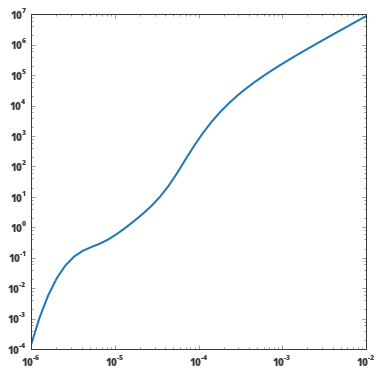

In [59]:
loglog(well_diams**2, sum(array(all_timesums),axis=1))

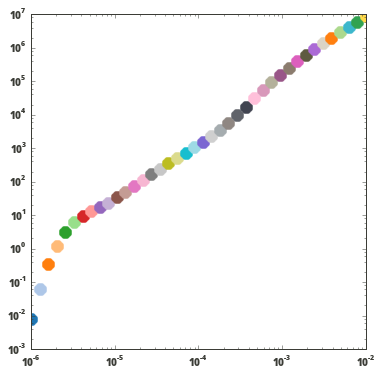

In [42]:
for (xval, timesum) in zip(well_diams**2, all_timesums):
    yval = sum(timesum)
    loglog(xval, yval, '.', markersize=25)
    
# nmstr = 'rough_mfpt_time_versus_well_squared_kappa=4e-1.pdf'
# savefig(nmstr)
# fig_annotate(nmstr, params)



# hold(True)
# loglog(well_diams**2, well_diams**4)
# # loglog(well_diams**2, well_diams**3)

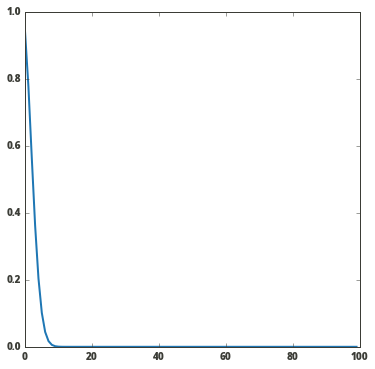

In [26]:
# Check to make sure that size of gaussian is reasonable 
# given the size of the simulation box

gauss = exp(-space**2/(4*(.01)**2))
gauss = gauss[:, None]
plot(gauss)

# Calculate first passage time distribution

In [ ]:
# Make a list of fht if you haven't already

all_fht = list()
for spec_sol in allsol:
    all_fht.append( make_fht(times, spec_sol) )

/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: invalid value encountered in log


NameError: name 'fht' is not defined

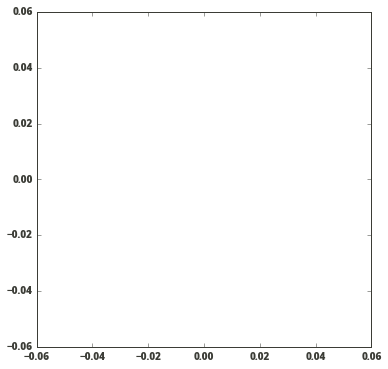

In [22]:
saveflag = False

figure()
hold(True)
all_tau = list()
all_laplace = list()
all_timescales = list()

for timesum in all_timesums:
    
    plot( times[::1000], log(log(timesum[::1000])) )
    
    # complete mean first passage time
    krate = mean( diff(log(timesum)) )
    krate = krate/mean( diff(times) )
    tau = -1/krate
    all_tau.append(tau)
    
    # calculate an approximate laplace transform
    timestep = median(diff(times))
    out = janky_laplace(timesum, num_lvls=200)
    amps = out[1]
    all_timescales.append(timestep/out[0])
    
    # don't take laplace of first-hitting distribution; 
    # take laplace of actual time traces
    
    all_laplace.append( amps[:,::1000].dot( timesum[::1000] )  )
    

if saveflag:
    savefig('xxx_pdeoft_for_various_potdiam.pdf')


# figure()
# hold(True)
# for sq_diam, tau, in zip(well_diams**2, all_tau):
#     loglog(sq_diam,tau,'.',markersize=25)
# if saveflag:
#     savefig('xxmfpt_versus_potdiam.pdf')


# figure()
# hold(True)                      
# for timescale, lapt in zip(all_timescales, all_laplace):
#     loglog(timescale, lapt,'.')
# if saveflag:
#     savefig('all_laplace_pde.pdf')



In [17]:
len(all_timesums)

20

/Users/william/miniconda/envs/spakenv/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


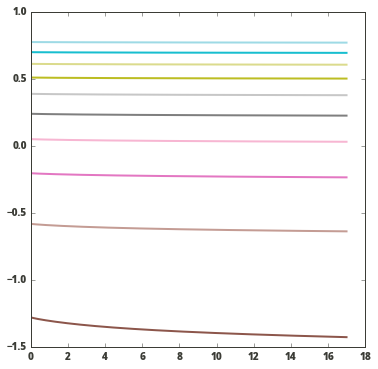

In [15]:
hold(True)
for timesum in all_timesums:
    plot( times[::1000], log(log(timesum[::1000])) )
# ylim([-1,1])

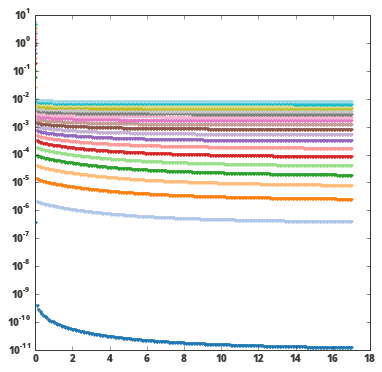

In [91]:
figure()
hold(True)                      
for timescale, lapt in zip(all_timescales, all_laplace):
    semilogy(timescale, lapt,'.')
if saveflag:
    savefig('all_laplace_pde.pdf')

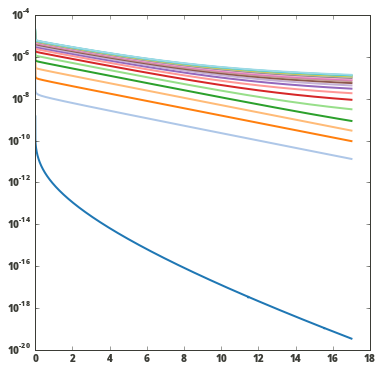

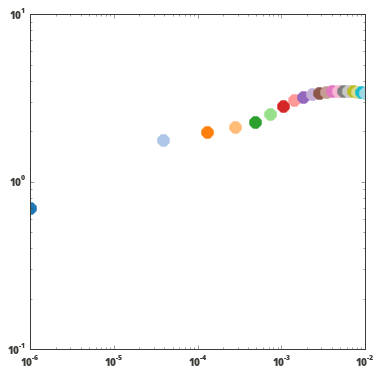

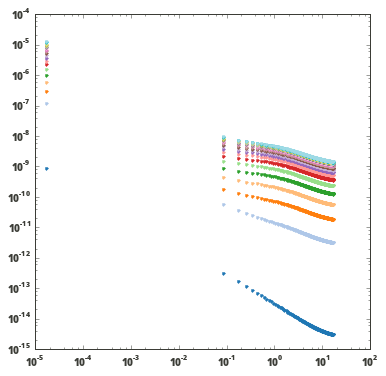

In [77]:
# # sol_time = sum(sol, axis = 0)

# saveflag = True

# figure()
# hold(True)
# all_tau=list()
# all_laplace = list()
# all_timescales = list()
# for fht in all_fht:
    
#     semilogy(times[:-1],fht)
    
#     # complete mean first passage time
#     krate = mean( diff(log(fht)) )
#     krate = krate/mean( diff(times) )
#     tau = -1/krate
#     all_tau.append(tau)
    
#     # calculate an approximate laplace transform
#     timestep = median(diff(times))
#     out = janky_laplace(fht, num_lvls=200)
#     amps = out[1]
#     all_timescales.append(timestep/out[0])
    
#     # don't take laplace of first-hitting distribution; 
#     # take laplace of actual time traces
    
#     all_laplace.append( amps[:,::1000].dot( fht[::1000] )  )
    
    

# if saveflag:
#     savefig('first_hitting_dists_for_various_potdiam.pdf')


# figure()
# hold(True)
# for sq_diam, tau, in zip(well_diams**2, all_tau):
#     loglog(sq_diam,tau,'.',markersize=25)
# if saveflag:
#     savefig('mfpt_versus_potdiam.pdf')


# figure()
# hold(True)                      
# for timescale, lapt in zip(all_timescales, all_laplace):
#     loglog(timescale, lapt,'.')
# if saveflag:
#     savefig('all_laplace_fht.pdf')



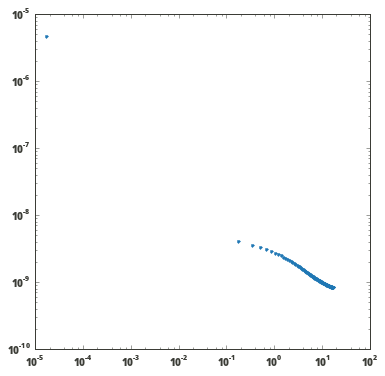

In [179]:
timestep = median(diff(times))

out = janky_laplace(fht, num_lvls=100)
amps = out[1]

timescales = timestep/out[0]

# downsample to plot
loglog(timescales, amps[:,::1000].dot(fht[::1000]),'.')
# savefig('laplace_fht.pdf')

In [91]:
## pick parameter values


def timescale_vs_asquared(well_diams, save_full_sol=False):
    '''
    Estimate the characteristic timescale of the reaction diffusion system 
    as a function of the well diameter. This code does not save the full 
    solution for memory reasons.
    
    params_and_settings : dict()
    
        All of the settings and parameters necessary to build the integrator
        
        
    TODO: add required argument params_and_settings so that no calls or writes are ever made to 
            stuff like timestep counts, etc
        
        
    
    '''
    
    # make a protective copy of the entire system (this probably slows it down but is absolutely necessary)
    
    
                    

#     save_full_sol = False #not recommended for more than 10 points
    save_fht = False

    allsol = list()

    all_fht = list()

    all_timesums = list()


    for diam in well_diams:
        
        params['POT_DIAM'] = diam
        space_pts = 100
        ACTUAL_LENGTH = 10*params['POT_DIAM']
        dx = ACTUAL_LENGTH/space_pts
        space = linspace(0.0, ACTUAL_LENGTH, space_pts)
        space = space+dx
    
        settings['space'] = space
        
        # have to re-intialize because r is a generator expression
        r = ode(nxt_step, jacob).set_integrator('lsoda', with_jacobian=True)
        r.set_initial_value(y0, times[0])
        r.set_f_params([settings, params])
        r.set_jac_params([settings, params])
        t1 = stop_time

        sol = list()
        while r.successful() and r.t < t1:
            r.integrate(r.t+dt)
            sol.append(r.y)
        sol = array(real(sol)).T

        gauss = exp(-space**2/(4*params['POT_DIAM']**2))
        gauss = gauss[:, None]
        sol = sol*gauss

        radpart = 4*pi*(space**2)
        radpart = radpart[:, None]
        sol = sol*radpart

        # integrate out space
        timesum = sum(sol, axis = 0)
        all_timesums.append( timesum )

        if save_full_sol:
            allsol.append( sol )

        if save_fht:
            all_fht.append( -diff(timesum) )


        print (diam)
        
    return array(all_timesums)


def timescale_vs_asquared_vs_kappa(well_diams, kvals):
    
    outs = list()
    
    for kval in kvals:
        params['KAPPA'] = kval
        outs.append( sum(timescale_vs_asquared(well_diams), axis=1) )
        
    return outs
        

def timescale_vs_asquared_vs_rxndiam(well_diams, rxn_diam_vals):
    
    outs = list()
    
    for rxn_diam in rxn_diam_vals:
        params['WELL_DIAM'] = rxn_diam
        outs.append( sum(timescale_vs_asquared(well_diams), axis=1) )
        
    return outs

In [104]:
params['KAPPA'] = 4e-1

well_diams = expspace(.01,.1, 20)

outs = timescale_vs_asquared(well_diams)

0.01
0.0112883789168
0.012742749857
0.0143844988829
0.0162377673919
0.0183298071083
0.0206913808111
0.0233572146909
0.0263665089873
0.0297635144163
0.0335981828628
0.0379269019073
0.0428133239872
0.0483293023857
0.0545559478117
0.0615848211066
0.0695192796178
0.0784759970351
0.088586679041
0.1


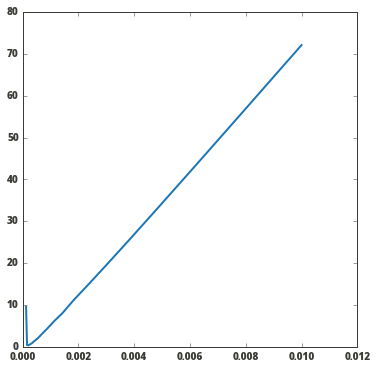

In [108]:
plot((well_diams**2)[1:], dt*sum(outs,axis=1)[1:],'-')

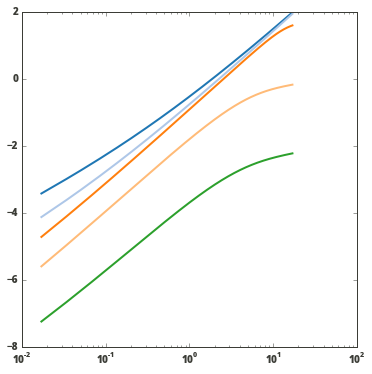

In [168]:
mm = outs[6::5,::1000].T/outs[6::5,0].T

mm2 = outs[6::5,::1000]

# semilogy( times[::1000], mm )

semilogx( times[::1000], log( -(log(mm)) ))


# savefig('doublelogy_v.logt.pdf')

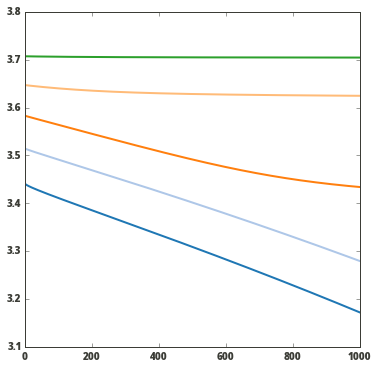

In [136]:
plot( log(40+log(outs[6::5,::1000].T)) )
print('')

In [76]:
well_diams = expspace(.001,.1, 30)
kvals = expspace(4e-1, 1e-1, 3)
# kvals = linspace(1e-4,1e-5, 2)
outs = timescale_vs_asquared_vs_kappa(well_diams, kvals)

0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.00188739182214
0.00221221629107
0.0025929437974
0.00303919538231
0.00356224789026
0.00417531893656
0.00489390091848
0.00573615251045
0.0067233575365
0.00788046281567
0.00923670857187
0.0108263673387
0.0126896100317
0.0148735210729
0.017433288222
0.0204335971786
0.0239502661999
0.0280721620394
0.0329034456231
0.0385662042116
0.0452035365636
0.0529831690628
0.0621016941892
0.0727895384398
0.0853167852417
0.1
0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.00188739182214
0.00221221629107
0.0025929437974
0.00303919538231
0.00356224789026
0.00417531893656
0.00489390091848
0.00573615251045
0.0067233575365
0.00788046281567
0.00923670857187
0.0108263673387
0.0126896100317
0.0148735210729
0.017433288222
0.0204335971786
0.0239502661999
0.0280721620394
0.0329034456231
0.0385662042116
0.0452035365636
0.0529831690628
0.0621016941892
0.0727895384398
0.0853167852417
0.1
0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.001

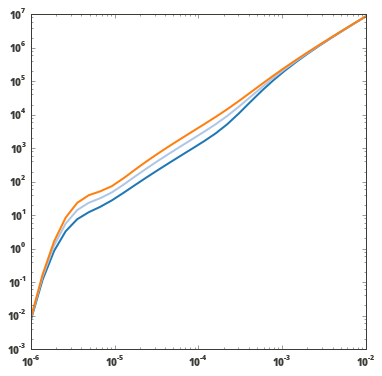

In [121]:
figure()
hold(True)
# loglog(well_diams**2, 5e6*rouse_time(well_diams),'.k')
# loglog(well_diams**2, 3e5*rxn_time(well_diams),'.k')

loglog(well_diams**2, array(outs).T)

nmstr = 'k_1e-1_4e-1.pdf'
# savefig(nmstr)
# fig_annotate(nmstr,params)


In [177]:
# NOW LOOK AT EFFECTS OF RXN ZONE WIDTH

well_diams = expspace(.001,.1, 30)
rxn_diam_vals = linspace(.01,.3,5)
# kvals = linspace(1e-4,1e-5, 2)
outs = timescale_vs_asquared_vs_rxndiam(well_diams, rxn_diam_vals)

0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.00188739182214
0.00221221629107
0.0025929437974
0.00303919538231
0.00356224789026
0.00417531893656
0.00489390091848
0.00573615251045
0.0067233575365
0.00788046281567
0.00923670857187
0.0108263673387
0.0126896100317
0.0148735210729
0.017433288222
0.0204335971786
0.0239502661999
0.0280721620394
0.0329034456231
0.0385662042116
0.0452035365636
0.0529831690628
0.0621016941892
0.0727895384398
0.0853167852417
0.1
0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.00188739182214
0.00221221629107
0.0025929437974
0.00303919538231
0.00356224789026
0.00417531893656
0.00489390091848
0.00573615251045
0.0067233575365
0.00788046281567
0.00923670857187
0.0108263673387
0.0126896100317
0.0148735210729
0.017433288222
0.0204335971786
0.0239502661999
0.0280721620394
0.0329034456231
0.0385662042116
0.0452035365636
0.0529831690628
0.0621016941892
0.0727895384398
0.0853167852417
0.1
0.001
0.00117210229753
0.00137382379588
0.00161026202756
0.001

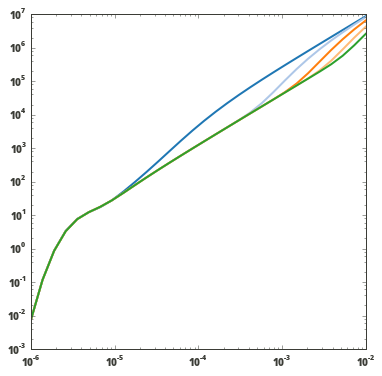

In [191]:
figure()
hold(True)
# loglog(well_diams**2, 5e6*rouse_time(well_diams),'.k')
# loglog(well_diams**2, 3e5*rxn_time(well_diams),'.k')

loglog(well_diams**2, array(outs).T)

# nmstr = 'vary_rxnzone_kappa_4e-1_potdiam_.1.pdf'
# savefig(nmstr)
# fig_annotate(nmstr,params)

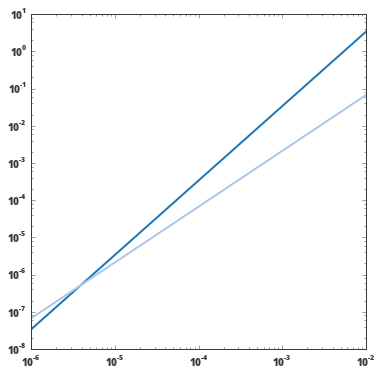

In [190]:
# Analytic predictions

figure()
# hold(True)
loglog(well_diams**2, rouse_time(well_diams))
loglog(well_diams**2, rxn_time(well_diams))
savefig('rouse_and_rxn_times.pdf')

In [195]:
out.shape()

NameError: name 'out' is not defined

In [181]:
def rouse_time(avals):
    '''
    Return the Rouse time
    '''
    return (1/(3*(pi**2)*params['DCOEFF']))*(avals)**4


def rxn_time(avals):
    '''
    Return the Rouse time
    a is the diameter of hte well
    '''
    return 1/(params['KAPPA']*(4/3)*pi*(params['WELL_DIAM']**3)*((3/(2*pi*(avals)**2))**1.5))


In [ ]:
## pick parameter values


def timescale_vs_param(param_name, param_range):
    '''
    Estimate the characteristic timescale of the reaction diffusion system 
    as a function of somr parameter. This code does not save the full 
    solution for memory reasons.
    '''
                    

    save_full_sol = False #not recommended for more than 10 points
    save_fht = False

    allsol = list()

    all_fht = list()

    all_timesums = list()


    for param_val in param_range:
        
        params['param_name'] = param_val

        # have to re-intialize because r is a generator expression
        r = ode(nxt_step, jacob).set_integrator('lsoda', with_jacobian=True)
        r.set_initial_value(y0, times[0])
        r.set_f_params([settings, params])
        r.set_jac_params([settings, params])
        t1 = stop_time

        sol = list()
        while r.successful() and r.t < t1:
            r.integrate(r.t+dt)
            sol.append(r.y)
        sol = array(real(sol)).T

        gauss = exp(-space**2/(4*params['POT_DIAM']**2))
        gauss = gauss[:, None]
        sol = sol*gauss

        radpart = 4*pi*(space**2)
        radpart = radpart[:, None]
        sol = sol*radpart

        # integrate out space
        timesum = sum(sol, axis = 0)
        all_timesums.append( timesum )

        if save_full_sol:
            allsol.append( sol )

        if save_fht:
            all_fht.append( -diff(timesum) )


        print (diam)
        
    return array(all_timesums)


def timescale_vs_param1_vs_param2(param1_name, param1_range, param2_name, param2_range):
    
    outs = list()
    
    for kval in kvals:
        params['KAPPA'] = kval
        outs.append( sum(timescale_vs_asquared(well_diams), axis=1) )
        
    return outs
        
        
    

# Appendix code

In [ ]:
import unittest

class IntegratorTest(unittest.TestCase):
    def test(self):
        self.assertEqual(fun(3), 4)